In [401]:
import pandas as pd
import numpy as np


# preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
import pywt
from umap import UMAP


# visualization
import matplotlib.pyplot as plt
import plotly.express as px


AMPLITUDE_THRESHOLD = 0.06


df = pd.read_csv("/home/alpha/programs/python_files/datasets/cnv_and_mut/entities_transformed.csv")

# basic filtering. Rename Unnamded 0 with ID. Dropp chromosomes Y and X
# df = df.dropna(axis=1)
df = df.fillna(0)
# df = df.rename(columns={"Unnamed: 0": "ID"})
df = df[df.columns.drop(list(df.filter(regex='[YX]')))]

print(df.head())
# Make it amplitude agnostic (experimental) 
def stupid_custom_filter(df=df,AMPLITUDE_THRESHOLD=AMPLITUDE_THRESHOLD):
    # temporary drop non digit columns
    helper_df = df[["entity","ID"]]
    df = df.drop(columns=["entity","ID"])
    # standardize and normalize data
    df = (df-df.mean())/df.std()
    df = 2*((df-df.min())/(df.max()-df.min()))-1
    # apply the filter
    df[df < -AMPLITUDE_THRESHOLD] = -1
    df[df > AMPLITUDE_THRESHOLD] = 1
    df[(df <= AMPLITUDE_THRESHOLD) & (df >= -AMPLITUDE_THRESHOLD)] = 0
    # append the dropped columns on the filtered dataframe
    df["ID"] = helper_df["ID"]
    df["entity"] = helper_df["entity"]
    
    return df

# df = stupid_custom_filter()



# Make features
features = df.columns.tolist()
features.remove("entity")
features.remove("ID")

print(df.head())

                    ID       0       1       2       3       4       5  \
0  206054070144_R04C01 -0.0005 -0.2910 -0.3570 -0.2575 -0.2340 -0.2310   
1  207343240049_R06C01 -0.2295 -0.6250 -0.5750 -0.7095 -0.5675 -0.5005   
2  203273200231_R06C01 -0.0690 -0.1290 -0.1820 -0.1045 -0.0695 -0.3825   
3  205041760139_R08C01  0.0270 -0.0515 -0.1315 -0.1105 -0.1370 -0.1645   
4  205617070063_R08C01  0.0245 -0.0935 -0.1435 -0.0830 -0.1730 -0.0805   

        6       7       8  ...    3872    3873    3874    3875   3876    3877  \
0 -0.3085 -0.3390 -0.2685  ... -0.4200 -0.3695 -0.2485 -0.2060 -0.098 -0.0920   
1 -0.7450 -0.7650 -0.6125  ... -0.2540 -0.1175 -0.2230 -0.0920 -1.992 -5.8405   
2 -0.3995 -0.4300 -0.3430  ... -0.1885 -0.2180 -0.0930 -0.2615 -0.203 -0.0620   
3 -0.2510 -0.1075 -0.0395  ... -0.2740 -0.2605 -0.1490 -0.0820  0.127 -0.0175   
4 -0.1280 -0.1295 -0.1435  ... -0.1870 -0.1040 -0.2045 -0.1000 -1.060  0.5380   

     3878    3879    3880   entity  
0 -0.4775 -0.1800 -0.3150  gbm_

## Standardization and denoising using PCA

Scaler to use (default StandardSclaer) : 
 1.StandardScaler 
 2.MinMaxScaler 
 3.RobustScaler 
 4.QuantileTransformer 
 2


[0.12349591 0.08921282 0.05243522 0.05020078 0.04072185 0.03262758] 0.04959214089809945


Text(0, 0.5, 'variance %')

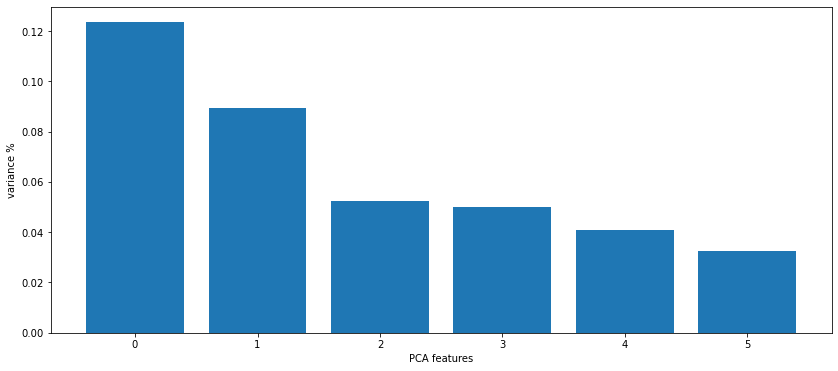

In [415]:
PRINCIPAL_COMPONENTS = 6

# make targets
x = df.loc[:,features].values
y_entity = df.loc[:,"entity"].values
y_id = df.loc[:,"ID"].values
x = 2*((x-x.min())/(x.max()-x.min()))-1

# test transform and preprocessing methods
def custom_preprocess(method=1,x=x):
    if method == 2:
        scaler = MinMaxScaler()
    elif method == 3:
        scaler = RobustScaler(quantile_range=(0.1,0.9))
    elif method == 4:
        scaler = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution="normal")
    else:
        print("using default StandardScaler")
        scaler = StandardScaler()
    return scaler.fit_transform(x)
    
method = int(input("Scaler to use (default StandardSclaer) : \n 1.StandardScaler \n 2.MinMaxScaler \n 3.RobustScaler \n 4.QuantileTransformer \n"))
x = custom_preprocess(method,x)


# PCA
pca_denoize = PCA(n_components=PRINCIPAL_COMPONENTS)
denoize = pca_denoize.fit_transform(x)
# print components which contribute to variance the most
variance = pca_denoize.explained_variance_ratio_
noise = pca_denoize.noise_variance_
print(variance, noise)

plt.figure(figsize=[14,6])
plt.bar(range(variance.shape[0]),variance)
plt.xlabel('PCA features')
plt.ylabel('variance %')


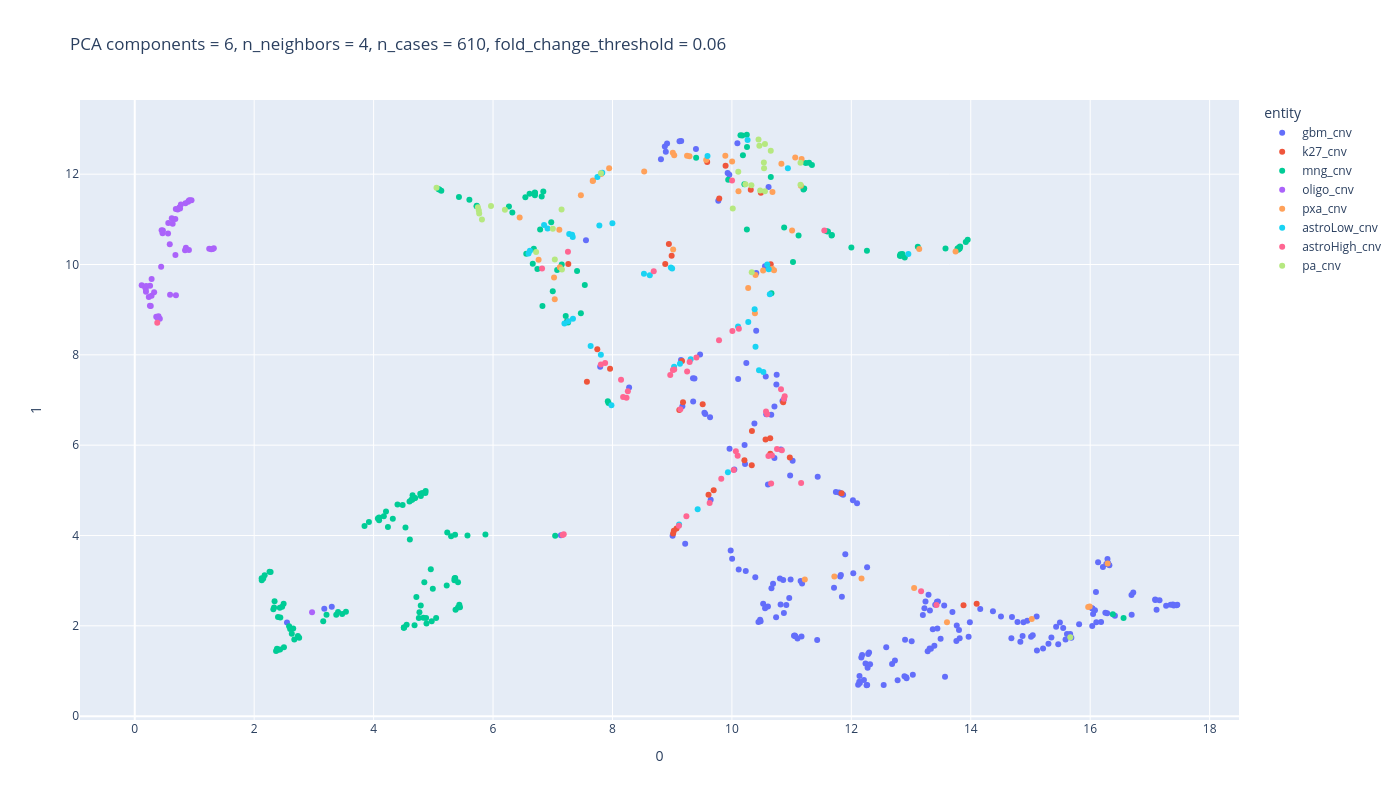

In [418]:
N_NEIGHBORS = 4

umap_2d = UMAP(n_neighbors=N_NEIGHBORS,n_epochs=200,random_state=1,spread=1,min_dist=0.1)
umap_2d.fit(denoize)

projections = umap_2d.transform(denoize)

fig = px.scatter(
    projections, x=0, y=1,
    title= f'PCA components = {PRINCIPAL_COMPONENTS}, n_neighbors = {N_NEIGHBORS}, n_cases = {df.shape[0]}, fold_change_threshold = {AMPLITUDE_THRESHOLD}' ,
    color=y_entity.astype(str), labels={'color': 'entity'},
    opacity=1
)

fig.update_layout(width=1200, height=800)

fig.show()